<a href="https://colab.research.google.com/github/AashiDutt/AI-and-ML-for-Coders/blob/main/Chapter_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Creating ML models to predict sequences

This repository contains code for:

1. Creating a windowed Dataset

2. Using Learning Rate Scheduler

3. Keras Tuner Tool to tune hyperparameters

In [19]:
# Creating windowed dataset

import tensorflow as tf
import numpy as np


In [20]:
dataset = tf.data.Dataset.range(10) #dataset contains values from 0 to n-1 (n = 10)

#split dataset into windows of 5 items, then shift window by 1, 
#drop_remainder - when window reaches end and items in window are less than 5, they should be dropped
dataset = dataset.window(5, shift = 1, drop_remainder = True)

#split dataset into batch of 5 windows
dataset = dataset.flat_map(lambda window:window.batch(5))

#split each window into everything before the last value and then last value
dataset = dataset.map(lambda window:(window[:-1], window[-1:]))

dataset = dataset.shuffle(buffer_size = 10)
dataset = dataset.batch(2).prefetch(1)

#This gives x and y dataset
for x, y in dataset:
  print("x = ",x.numpy()) 
  print("y = ",y.numpy())

x =  [[4 5 6 7]
 [1 2 3 4]]
y =  [[8]
 [5]]
x =  [[2 3 4 5]
 [0 1 2 3]]
y =  [[6]
 [4]]
x =  [[3 4 5 6]
 [5 6 7 8]]
y =  [[7]
 [9]]


In [21]:
def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
series = trend(time, 0.1)
baseline = 10
amplitude = 20
slope = 0.09
noise_level = 5

series = baseline + trend(time, slope) 
series += seasonality(time, period=365, amplitude=amplitude)
series += noise(time, noise_level, seed=42)




In [22]:
# Creating function for generating windowed dataset
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):

#from_tensor_slices - turn series into dataset  
  dataset = tf.data.Dataset.from_tensor_slices(series)

  dataset = dataset.window(window_size + 1, shift=1,drop_remainder=True)

  dataset = dataset.flat_map(lambda window:window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window:(window[:-1], window[-1]))

  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset


In [23]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]
window_size = 40 # 20
batch_size = 32
shuffle_buffer_size = 1000
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


In [24]:
#Looking at dataset
dataset = windowed_dataset(series, window_size, 1, shuffle_buffer_size)
for feature, label in dataset.take(1):
  print("feature ",feature)
  print("\n")
  print("label ", label)

feature  tf.Tensor(
[[35.90006  31.128325 36.56132  28.964384 31.70668  30.526445 33.42535
  44.65221  23.805752 36.63676  25.205479 30.973211 38.84165  33.78254
  28.13687  30.013733 37.05311  30.068363 34.867767 34.078815 30.658636
  44.702236 37.21819  23.989155 35.113605 30.93906  38.57701  30.419285
  33.875435 37.04147  38.91291  28.650434 33.04738  32.4133   31.589708
  43.75212  37.018444 28.757961 39.72072  45.81139 ]], shape=(1, 40), dtype=float32)


label  tf.Tensor([40.4323], shape=(1,), dtype=float32)


In [25]:
dataset = windowed_dataset(series, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
                                    tf.keras.layers.Dense(10, input_shape = [window_size], activation = "relu"),
                                    tf.keras.layers.Dense(10, activation = "relu"),
                                    tf.keras.layers.Dense(1)
])


In [48]:
model.compile(loss = "mse",optimizer = tf.keras.optimizers.SGD(lr = 1e-6, momentum = 0.9), metrics = ['accuracy'])
history = model.fit(dataset, epochs = 100, verbose = 1)

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


45/45 [==============================] - 1s 4ms/step - loss: 411.1821 - accuracy: 0.0000e+00
Epoch 2/100
45/45 [==============================] - 0s 5ms/step - loss: 55.2277 - accuracy: 0.0000e+00
Epoch 3/100
45/45 [==============================] - 0s 4ms/step - loss: 50.2974 - accuracy: 0.0000e+00
Epoch 4/100
45/45 [==============================] - 0s 4ms/step - loss: 51.7300 - accuracy: 0.0000e+00
Epoch 5/100
45/45 [==============================] - 0s 4ms/step - loss: 50.2473 - accuracy: 0.0000e+00
Epoch 6/100
45/45 [==============================] - 0s 3ms/step - loss: 46.8424 - accuracy: 0.0000e+00
Epoch 7/100
45/45 [==============================] - 0s 4ms/step - loss: 48.0476 - accuracy: 0.0000e+00
Epoch 8/100
45/45 [==============================] - 0s 3ms/step - loss: 48.8554 - accuracy: 0.0000e+00
Epoch 9/100
45/45 [==============================] - 0s 3ms/step - loss: 53.9749 - accuracy: 0.0000e+00
Epoch 10/100
45/45 [==============================] - 0s 4ms/step - loss: 4

In [57]:
print(series[1000:1040]) #(1040 -- replaced 1020 because window size changed from 20 to 40)


[109.170746 106.86935  102.61668   99.15634  105.95478  104.503876
 107.08533  105.858284 108.00339  100.15279  109.4894   103.96404
 113.426094  99.67773  111.87749  104.26137  100.08899  101.00105
 101.893265 105.69048  106.258606 100.85084  103.67259  114.580864
 112.5825   106.20179  104.2857   104.77147  107.314644  99.20896
 103.11202   96.13207  106.54732  107.863495 102.288025 112.65043
  98.728325  97.61204  106.13305  110.32325 ]


In [56]:
print(series[1040])

113.58449


In [55]:
print(model.predict(series[1000:1040][np.newaxis]))

[[108.158806]]


In [35]:
forecast = [] #array to store predicted values
for time in range(len(series) - window_size):
  forecast.append( #call predict for every time step
      model.predict(series[time:time + window_size][np.newaxis])
  )

In [36]:
# forecast array has values of predctions for time step 21 onwards -- winsow size is 20

forecast = forecast[split_time - window_size:]
results = np.array(forecast)[:,0,0]


In [31]:
#Chapter 9 code
def plot_series(time, series, format = "-", start = 0, end = None):
  plt.plot(time[start:end],series[start:end], format)
  plt.xlabel("Time")
  plt.ylabel("Value")
  plt.grid(True)

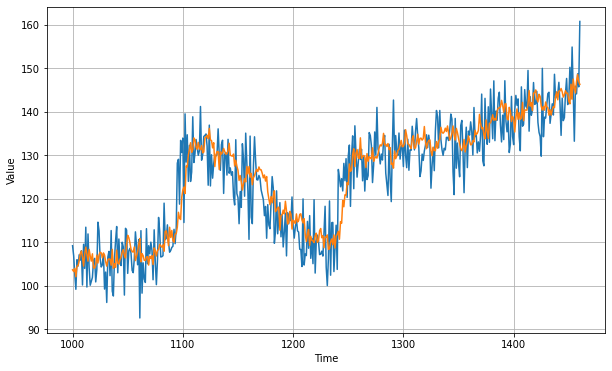

In [61]:
import matplotlib.pyplot as plt

plt.figure(figsize = (10,6))
plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [62]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

4.677437

In [63]:
#learning rate scheduler

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch:1e-8 * 10 **(epoch / 20))

In [64]:
optimizer = tf.keras.optimizers.SGD(lr = 1e-6, momentum = 0.9)
model.compile(loss = "mse", optimizer = optimizer, metrics = ['accuracy'])
history = model.fit(dataset, epochs = 100, callbacks=[lr_schedule], verbose = 1)

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


45/45 [==============================] - 1s 4ms/step - loss: 35.5561 - accuracy: 0.0000e+00 - lr: 1.0000e-08
Epoch 2/100
45/45 [==============================] - 0s 4ms/step - loss: 35.3851 - accuracy: 0.0000e+00 - lr: 1.1220e-08
Epoch 3/100
45/45 [==============================] - 0s 4ms/step - loss: 35.3748 - accuracy: 0.0000e+00 - lr: 1.2589e-08
Epoch 4/100
45/45 [==============================] - 0s 3ms/step - loss: 35.3735 - accuracy: 0.0000e+00 - lr: 1.4125e-08
Epoch 5/100
45/45 [==============================] - 0s 4ms/step - loss: 35.4094 - accuracy: 0.0000e+00 - lr: 1.5849e-08
Epoch 6/100
45/45 [==============================] - 0s 4ms/step - loss: 35.3847 - accuracy: 0.0000e+00 - lr: 1.7783e-08
Epoch 7/100
45/45 [==============================] - 0s 4ms/step - loss: 35.3789 - accuracy: 0.0000e+00 - lr: 1.9953e-08
Epoch 8/100
45/45 [==============================] - 0s 3ms/step - loss: 35.3649 - accuracy: 0.0000e+00 - lr: 2.2387e-08
Epoch 9/100
45/45 [=========================

(1e-06, 0.001, 0.0, 100.0)

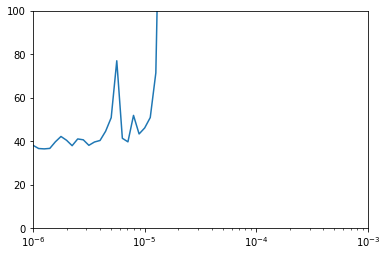

In [65]:
#loss plot

lrs = 1e-8 * (10 **(np.arange(100)/20))
plt.semilogx(lrs,history.history["loss"])
#plt.plot(lrs,history.history["loss"])
plt.axis([1e-6,1e-3,0,100])

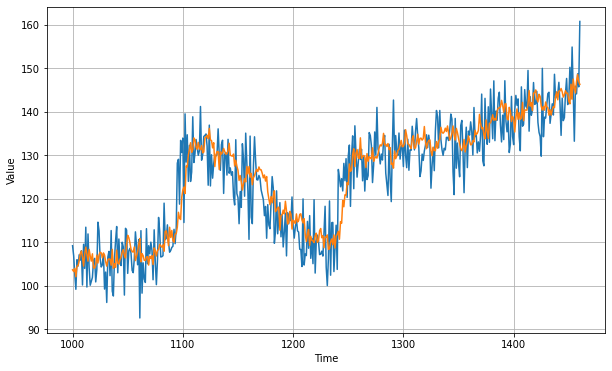

In [66]:
plt.figure(figsize = (10,6))
plot_series(time_valid, x_valid)
plot_series(time_valid, results)

**Window size = 20** **lr = 1e-6** 
loss = 1500+

**Window size = 40, lr = 1e-6**
loss = 35 and rising to 1500+

optimum lr became 1e-5

In [26]:
#Keras Tuner tool to parameterize hyperprameters 
!pip install keras-tuner

In [27]:
from kerastuner.tuners import RandomSearch 

In [28]:
# Cycle number of neurons in layers of model 
# this will train model 11 times, for different values of no. of neurons (10 to 30)

dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

def build_model(hp):
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Dense(units=hp.Int('units', min_value=10, max_value=30, step=2), activation='relu', input_shape=[window_size]))
  model.add(tf.keras.layers.Dense(10, activation='relu'))
  model.add(tf.keras.layers.Dense(1))

  model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(hp.Choice('momentum', values=[.9, .7, .5, .3]), lr=1e-5))
  return model

tuner = RandomSearch(build_model, objective='loss', max_trials=50, executions_per_trial=3, directory='my_dir', project_name='hello')

tuner.search_space_summary()

tuner.search(dataset, epochs=100, verbose=0)

INFO:tensorflow:Reloading Oracle from existing project my_dir/hello/oracle.json
INFO:tensorflow:Reloading Tuner from my_dir/hello/tuner0.json
Search space summary
Default search space size: 2
units (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 30, 'step': 2, 'sampling': None}
momentum (Choice)
{'default': 0.9, 'conditions': [], 'values': [0.9, 0.7, 0.5, 0.3], 'ordered': True}


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


INFO:tensorflow:Oracle triggered exit


In [29]:
models = tuner.get_best_models(num_models=4)


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [30]:
dataset = windowed_dataset(x_train, window_size, batch_size, 
                           shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(28, input_shape=[window_size], 
                           activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.5)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=100,  verbose=1)



Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


30/30 [==============================] - 0s 3ms/step - loss: 166.7363
Epoch 2/100
30/30 [==============================] - 0s 2ms/step - loss: 56.2514
Epoch 3/100
30/30 [==============================] - 0s 2ms/step - loss: 54.4491
Epoch 4/100
30/30 [==============================] - 0s 3ms/step - loss: 50.9739
Epoch 5/100
30/30 [==============================] - 0s 3ms/step - loss: 49.2933
Epoch 6/100
30/30 [==============================] - 0s 2ms/step - loss: 48.8508
Epoch 7/100
30/30 [==============================] - 0s 2ms/step - loss: 48.3450
Epoch 8/100
30/30 [==============================] - 0s 2ms/step - loss: 45.7029
Epoch 9/100
30/30 [==============================] - 0s 2ms/step - loss: 47.5950
Epoch 10/100
30/30 [==============================] - 0s 2ms/step - loss: 45.7718
Epoch 11/100
30/30 [==============================] - 0s 2ms/step - loss: 44.5781
Epoch 12/100
30/30 [==============================] - 0s 4ms/step - loss: 44.6641
Epoch 13/100
30/30 [================

In [33]:
import matplotlib.pyplot as plt


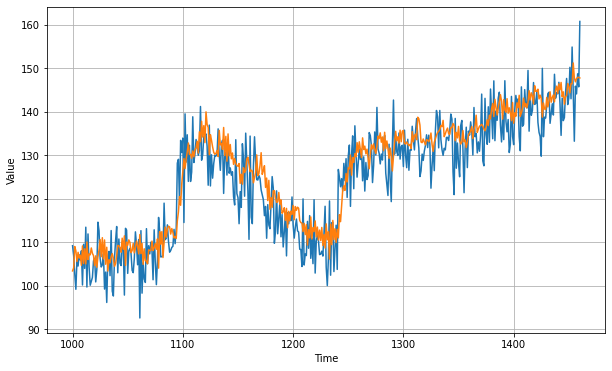

In [37]:
plt.figure(figsize = (10,6))
plot_series(time_valid, x_valid)
plot_series(time_valid, results)